In [112]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

# modeling
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import clone_model

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [2]:
def get_X_2d_uniform(n, x0_min, x0_max, x1_min, x1_max):
    x0s = np.random.uniform(x0_min, x0_max, size = n)
    x1s = np.random.uniform(x1_min, x1_max, size = n)
    return np.stack([x0s, x1s], axis = 1)

def get_X_2d_interval(n, x0_min, x0_max, x1_min, x1_max):
    x0s = np.linspace(x0_min, x0_max, num = n)
    x1s = np.linspace(x1_min, x1_max, num = n)
    x0, x1 = np.meshgrid(x0s, x1s)
    return np.stack([x0.flatten(), x1.flatten()], axis = 1)

def gen_sine(n, drifted = False):
    x0_min, x0_max = -3.14, 3.14
    x1_min, x1_max = -1, 1
    X = get_X_2d_uniform(n, x0_min, x0_max, x1_min, x1_max)
    y = np.array((X[:, 1] > np.sin(X[:, 0])) != drifted).astype(int)
    return X, y

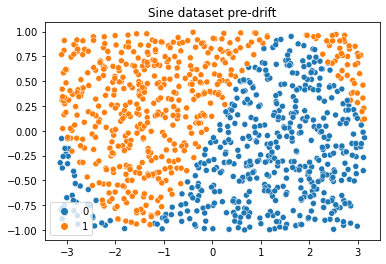

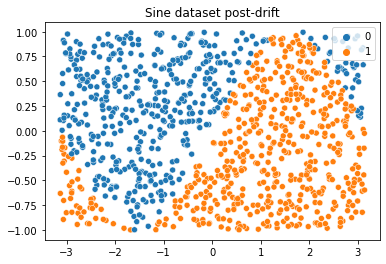

In [3]:
n_samples = 1000

X_pre, y_pre = gen_sine(n_samples)
X_post, y_post = gen_sine(n_samples, drifted = True)

plt.title('Sine dataset pre-drift')
sns.scatterplot(x = X_pre[:, 0], y = X_pre[:, 1], hue = y_pre)
plt.show()

plt.title('Sine dataset post-drift')
sns.scatterplot(x = X_post[:, 0], y = X_post[:, 1], hue = y_post)
plt.show()

In [164]:
def gen_sine_gradual(n, drifting = False):
    assert drifting == True
    x0_min, x0_max = -3.14, 3.14
    x1_min, x1_max = -1, 1
    X = get_X_2d_uniform(n, x0_min, x0_max, x1_min, x1_max)
    t = np.arange(n) / n
    phase = (x0_max - x0_min) / 2 * t
    y = np.array( X[:, 1] > (np.sin(X[:, 0] - phase)) ).astype(int)
    return X, y, t

/opt/conda/lib/python3.7/site-packages/seaborn/relational.py:654: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  kws["alpha"] = 1 if self.alpha == "auto" else self.alpha


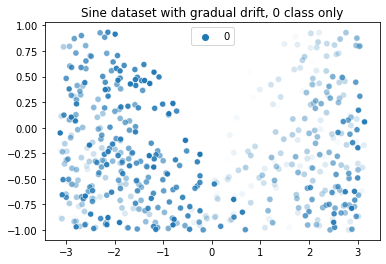

In [168]:
X_post_gradual, y_post_gradual, t_drift_gradual = gen_sine_gradual(n_samples, drifting = True)

plt.title('Sine dataset with gradual drift, 0 class only')
sns.scatterplot(x = X_post_gradual[:, 0][y_post_gradual == 0], y = X_post_gradual[:, 1][y_post_gradual == 0], hue = y_post_gradual[y_post_gradual == 0], alpha = t_drift_gradual[y_post_gradual == 0])
plt.show()

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X_pre, y_pre, test_size = 0.25)

In [5]:
def get_new_model():
    model = keras.Sequential(
        [
            keras.Input(shape = (2,)),
            keras.layers.Dense(4, activation="sigmoid"),
            keras.layers.Dense(1, activation='sigmoid')
        ]
    )

    model.compile(
        optimizer = 'adam',
        loss = 'binary_crossentropy',
        metrics = ['accuracy']
    )
    return model

In [120]:
model = get_new_model()
hist = model.fit(
    x = X_train,
    y = y_train,
    epochs = 200,
    validation_split = 0.1,
    verbose = 0
)

In [121]:
hist_df = pd.DataFrame.from_dict(hist.history)

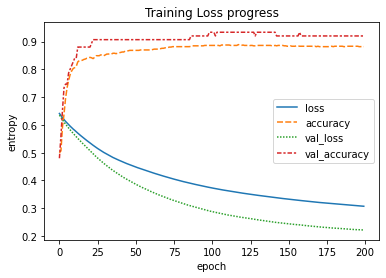

In [122]:
plt.title('Training Loss progress')

sns.lineplot(data = hist_df)
plt.xlabel('epoch')
plt.ylabel('entropy')
plt.show()

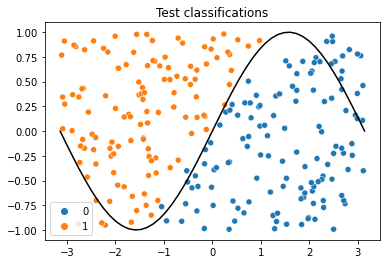

In [105]:
y_pre_pred = (model.predict(X_test)[:, 0] > 0.5).astype(int)

plt.title('Test classifications')

# training data 
#sns.scatterplot(x = X_train[:, 0], y = X_train[:, 1], hue = y_train, alpha = 0.1)

# pred data 
sns.scatterplot(x = X_test[:, 0], y = X_test[:, 1], hue = (y_pre_pred > 0.5).astype(int))

# underlying function
sns.lineplot(x = np.linspace(-3.14, 3.14), y = np.sin(np.linspace(-3.14, 3.14)), color = 'k')

plt.show()

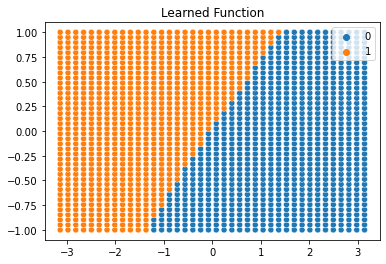

In [106]:
X_f = get_X_2d_interval(40, -3.14, 3.14, -1, 1)
y_pred_f = (model.predict(X_f)[:, 0] > 0.5).astype(int)

plt.title('Learned Function')

# pred data 
sns.scatterplot(x = X_f[:, 0], y = X_f[:, 1], hue = y_pred_f)

plt.show()

In [107]:
# pre-drift error rate
test_error_rate = 1 - accuracy_score(y_pre_pred, y_test)
print("Error rate pre-drift: %.1f%%" % (test_error_rate * 100))

Error rate pre-drift: 8.0%


Get the error rate over time to implement the Drift Detection Method

In [170]:
# get error rate over time with data that models the same concept as the test/train data
n_prod_pre = 1000
n_prod_post = 1000
X_prod_pre, y_prod_pre = gen_sine(n_prod_pre, drifted = False)
#X_prod_post, y_prod_post = gen_sine(n_prod_post, drifted = True)
X_prod_post, y_prod_post, _ = gen_sine_gradual(n_prod_post, drifting = True)

X_prod = np.vstack([X_prod_pre, X_prod_post])
y_prod = np.concatenate([y_prod_pre, y_prod_post])

In [171]:
err_rate_seq = []
err_sd_seq = []

err_rate_min = np.inf
err_sd_min = np.inf

n_errors = n_examples_seen = 0

# detection thresholds
warning_deviations = 2
drift_deviations = 3

warmup_time = 100 # needed to approximate normal distribution

# go through examples one-at-a-time
for t, (X, y) in enumerate(zip(X_prod, y_prod)):
    
    X = np.expand_dims(X, axis = 0)
    y_pred = int(model.predict(X)[0] > 0.5)
    
    # increment counters
    n_errors = n_errors + 1 if y_pred != y else n_errors
    n_examples_seen += 1
    
    # calculate metrics: standard deviation and error rate
    err_rate = n_errors / n_examples_seen
    err_sd = np.sqrt( err_rate * (1 - err_rate) / n_examples_seen )
    
    # update min registers
    if err_rate + err_sd < err_rate_min + err_sd_min and t > warmup_time:
        err_rate_min, err_sd_min = err_rate, err_sd
    
    err_rate_seq.append(err_rate)
    err_sd_seq.append(err_sd)

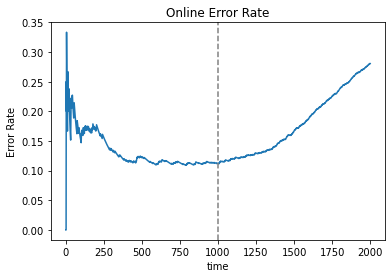

In [172]:
plt.title("Online Error Rate")
sns.lineplot(x = np.arange(0, n_prod_pre + n_prod_post), y = err_rate_seq)
plt.axvline(n_prod_pre, color = 'gray', linestyle = '--')
plt.ylabel('Error Rate')
plt.xlabel('time')
plt.show()

In [173]:
err_rate

0.2805

Above, the horizontal line is the test set error rate (pre-prod) and the vertial line is when the sudden drift happened in the prod data. We can see the error rate increasing dramatically at this point.

This image from Gama et al (2004) shows the same trend.
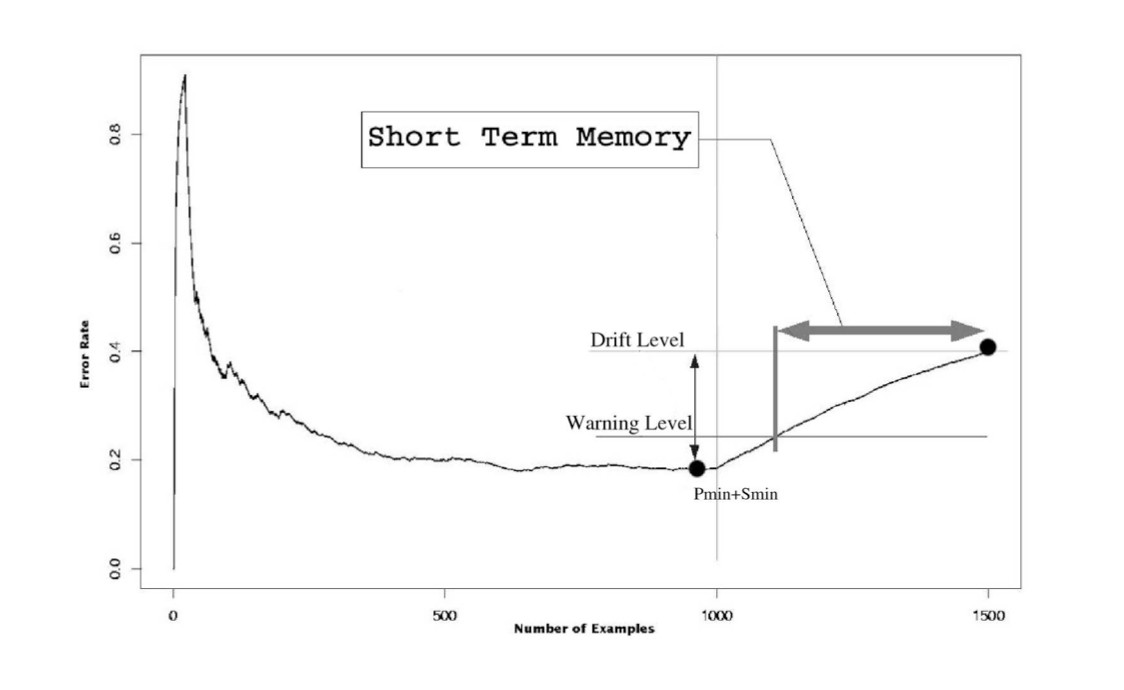

In [174]:
# deployment re-training simulation

err_rate_seq_intervention = []
err_sd_seq = []

err_rate_min = np.inf
err_sd_min = np.inf

n_errors = n_examples_seen = 0
t_min = 0

# detection thresholds
warning_deviations = 2
drift_deviations = 3

warmup_duration = 100 # needed to approximate normal distribution
warmup_time = 0
min_window_size = 0

retrain_database = []

# deep copy of trained model for deployment / retraining
current_model = get_new_model()
current_model.set_weights(model.get_weights())

early_stopper = EarlyStopping(monitor='loss', patience=3)

# go through examples one-at-a-time
for t, (X, y) in enumerate(zip(X_prod, y_prod)):
    
    X = np.expand_dims(X, axis = 0)
    y_pred = int(current_model.predict(X)[0] > 0.5)
    
    # increment counters
    n_errors = n_errors + 1 if y_pred != y else n_errors
    n_examples_seen += 1
    
    # calculate metrics: standard deviation and error rate
    err_rate = n_errors / n_examples_seen
    err_sd = np.sqrt( err_rate * (1 - err_rate) / n_examples_seen )
    err_rate_seq_intervention.append(err_rate)
    err_sd_seq.append(err_sd)
    
    # update min registers
    if err_rate + err_sd < err_rate_min + err_sd_min and t > warmup_time + warmup_duration:
        err_rate_min, err_sd_min = err_rate, err_sd
        t_min = t
    
    if err_rate + err_sd >= err_rate_min + warning_deviations * err_sd_min and t > warmup_time + warmup_duration:
        retrain_database.append((X, y))
    else:
        retrain_database = [] # false alarm
        
    if err_rate + err_sd >= err_rate_min + drift_deviations * err_sd_min and t > warmup_time + warmup_duration and len(retrain_database) > min_window_size:
        X_train_new = np.stack([X[0] for (X, y) in retrain_database])
        y_train_new = np.array([y for (X, y) in retrain_database])
        
        print('training a new model on %d datapoints at t = %d' % (len(y_train_new), t))
        model_new = get_new_model()
        model_new.fit(
            x = X_train_new,
            y = y_train_new,
            epochs = 1000,
            verbose = 0,
            callbacks = [early_stopper]
        )
        current_model = model_new # replace model with new learner
        warmup_time += warmup_duration
        err_rate_min = np.inf
        err_sd_min = np.inf

training a new model on 171 datapoints at t = 1315
training a new model on 66 datapoints at t = 1508
training a new model on 119 datapoints at t = 1711


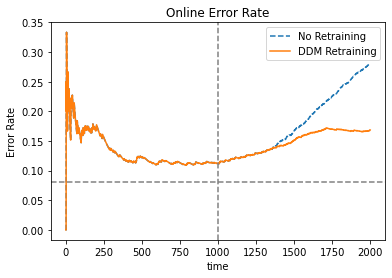

In [175]:
plt.title("Online Error Rate")
sns.lineplot(x = np.arange(0, n_prod_pre + n_prod_post), y = err_rate_seq, linestyle = '--', label = 'No Retraining')
sns.lineplot(x = np.arange(0, n_prod_pre + n_prod_post), y = err_rate_seq_intervention, label = 'DDM Retraining')
plt.axhline(test_error_rate, color = 'gray', linestyle = '--')
plt.axvline(n_prod_pre, color = 'gray', linestyle = '--')
#plt.axvline(t_warning, color = 'purple', linestyle = '--')
#plt.axvline(t_drift, color = 'purple', linestyle = '--')
plt.ylabel('Error Rate')
plt.xlabel('time')
plt.show()

In [176]:
err_rate

0.1685

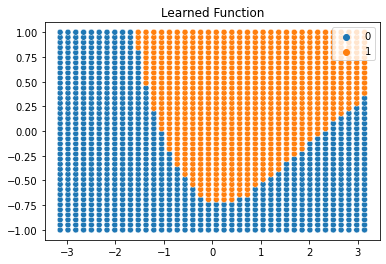

In [177]:
X_f = get_X_2d_interval(40, -3.14, 3.14, -1, 1)
y_pred_f = (model_new.predict(X_f)[:, 0] > 0.5).astype(int)

plt.title('Learned Function')

# pred data 
sns.scatterplot(x = X_f[:, 0], y = X_f[:, 1], hue = y_pred_f)

plt.show()

Online Retraining

In [178]:
# deployment re-training simulation

impressions_per_example = 10

err_rate_seq_intervention2 = []

current_model = get_new_model()
current_model.set_weights(model.get_weights())

# go through examples one-at-a-time
for t, (X, y) in enumerate(zip(X_prod, y_prod)):
    
    if t % 100 == 0:
        print(t)
    
    X = np.expand_dims(X, axis = 0)
    y_pred = int(current_model.predict(X)[0] > 0.5)
    
    # increment counters
    n_errors = n_errors + 1 if y_pred != y else n_errors
    n_examples_seen += 1
    
    # calculate metrics: standard deviation and error rate
    err_rate = n_errors / n_examples_seen
    err_rate_seq_intervention2.append(err_rate)
    
    # online retrain
    if y_pred != y:
        current_model.fit(
            x = np.array(X.tolist() * impressions_per_example),
            y = np.array([y] * impressions_per_example),
            epochs = 1,
            verbose = 0
        )

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900


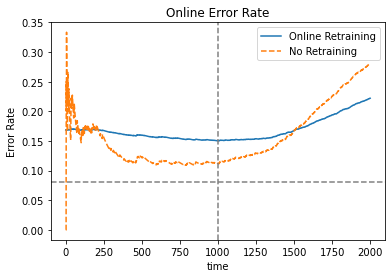

In [179]:
plt.title("Online Error Rate")
sns.lineplot(x = np.arange(0, n_prod_pre + n_prod_post), y = err_rate_seq_intervention2, label = 'Online Retraining')
sns.lineplot(x = np.arange(0, n_prod_pre + n_prod_post), y = err_rate_seq, linestyle = '--', label = 'No Retraining')
plt.axhline(test_error_rate, color = 'gray', linestyle = '--')
plt.axvline(n_prod_pre, color = 'gray', linestyle = '--')
plt.ylabel('Error Rate')
plt.xlabel('time')
plt.show()

In [180]:
err_rate

0.222

In [181]:
# deployment re-training simulation

err_rate_seq_intervention3 = []

retrain_database = []

current_model = get_new_model()
current_model.set_weights(model.get_weights())

batch_size = 40

# go through examples one-at-a-time
for t, (X, y) in enumerate(zip(X_prod, y_prod)):
    
    if t % 100 == 0:
        print(t)
    
    X = np.expand_dims(X, axis = 0)
    y_pred = int(current_model.predict(X)[0] > 0.5)
    
    # increment counters
    n_errors = n_errors + 1 if y_pred != y else n_errors
    n_examples_seen += 1
    
    # calculate metrics: standard deviation and error rate
    err_rate = n_errors / n_examples_seen
    err_rate_seq_intervention3.append(err_rate)
    
    retrain_database.append((X, y))
    
    # Small-Batch online retrain
    if len(retrain_database) == batch_size:
        
        X_train_new = np.stack([X[0] for (X, y) in retrain_database])
        y_train_new = np.array([y for (X, y) in retrain_database])
        retrain_database = []
        
        current_model.fit(
            x = X_train_new,
            y = y_train_new,
            epochs = 10,
            verbose = 0
        )

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900


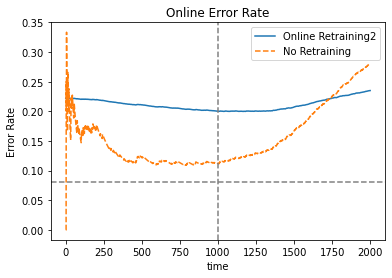

In [182]:
plt.title("Online Error Rate")
sns.lineplot(x = np.arange(0, n_prod_pre + n_prod_post), y = err_rate_seq_intervention3, label = 'Online Retraining2')
sns.lineplot(x = np.arange(0, n_prod_pre + n_prod_post), y = err_rate_seq, linestyle = '--', label = 'No Retraining')
plt.axhline(test_error_rate, color = 'gray', linestyle = '--')
plt.axvline(n_prod_pre, color = 'gray', linestyle = '--')
plt.ylabel('Error Rate')
plt.xlabel('time')
plt.show()

In [183]:
err_rate

0.235